In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
matplotlib.rcParams['figure.figsize'] = (15, 10)


# Load Data from Postgis Database

The data has already been loaded in to a Postgres database with the [Postgis](https://postgis.net/) extension to allow for geometric manipulations (covered in a previous post LINK).
I mostly just want all of the table data to begin with. 
I could probably parse down what I am getting here based on location but it doesn't make a whole lot of difference right now.

I am adding the distance to representative latitude and longitude positions for Minneapolis and St. Paul as a lazy proxy for "suburban" and "urban" definitions to see if these are important considerations.
Postgis makes this very simple and uses a spheroid calculation with the 4326 projection.

To calculate the distance from St. Paul to a given geometry, I use the `ST_Distance` function which finds the geodesic distance between the provided point for St. Paul and the `geom_c` column of the election table which was calculated during database population.
The `ST_Distance` function uses a spheroid distance caluclation when `geography` types are specified.

```
ST_Distance('SRID=4326;POINT(-93.2650 -44.9537)'::geography, e.geom_c)
```


In [2]:
import psycopg2  # (if it is postgres/postgis)
from dotenv import load_dotenv
load_dotenv("../.env")
con = psycopg2.connect(database="postgres", user="postgres", password=os.getenv("POSTGRES_PASSWORD"), host="localhost")

stpaul = "-93.0900 -44.9537"
minneapolis = "-93.2650 44.9778"
sql = f"select *, ST_Distance('SRID=4326;POINT({stpaul})'::geography, e.geom_c) as stp_dis, ST_Distance('SRID=4326;POINT({minneapolis})'::geography, e.geom_c) as mpls_dis from election e"
election_data = gpd.read_postgis(sql, con)
sql = f"select * from parcels"
org_parcel_data = gpd.read_postgis(sql, con)
con.close()

In [3]:
# 2012 uses a "vtd" column while every other year uses "vtdid" so quick fix for that 
election_data["vtdid"] = election_data["vtdid"].fillna(election_data["vtd"]).drop(columns="vtd")
# Add city_dis column
election_data["cit_dis"] = election_data[["stp_dis", "mpls_dis"]].min(axis=1)/1609.344 # meters to miles

# Limiting Parcels
For now, I want to look at only "single-family residental" parcels.
Analysis could be done with additional residental parcel categories, but there is a lot of missing info on the size of the buildings with condomimums and apartments that make it difficult to accurately analyze with these included.


In [96]:
single_family = ["100 Res 1 unit", "Res 1 unit", "100 Res 1 Unit", "Residential", "RESIDENTIAL SINGLE FAMILY", 'RESIDENTIAL', 'Residential Lakeshore']
res_mask = org_parcel_data["useclass1"].isin(single_family)
parcel_data = org_parcel_data.loc[res_mask]

Additionally, limiting the information used from the parcels to total estimated value (`emv_total`), year built (`year_built`), and last sale date (`sale_date`).

# Get Precinct Statistics

The parcel data is tagged by precinct for each year that geographic parcel information was available under columns coded as `vtdid_{YEAR}`.
This

In [97]:
cols = ["emv_total", "year_built", "sale_date"] + [col for col in parcel_data.columns if "vtd" in col]
parcel_data = parcel_data.loc[:, cols]

In [98]:
vtd_cols = [col for col in parcel_data.columns if "vtd" in col]
id_cols = [col for col in parcel_data.columns if "vtd" not in col]
pivot_data = parcel_data.melt(id_vars=id_cols, value_vars = vtd_cols, var_name="year", value_name="vtdid")
pivot_data["year"] = pivot_data["year"].str.strip("vtdid_").astype(np.int)
pivot_data

,emv_total,year_built,sale_date,year,vtdid
0,281500,2013,2003.0,2012,270190117
1,280600,2013,2001.0,2012,270190117
2,281500,2013,1982.0,2012,270190117
3,421800,2005,1977.0,2012,271390015
4,358100,1900,1970.0,2012,271390015
...,...,...,...,...,...
4029950,331700,1910,1950.0,2020,270190135
4029951,493400,1973,1967.0,2020,270190135
4029952,344400,1900,1977.0,2020,271390015
4029953,335500,1903,1991.0,2020,271390015


In [99]:
def create_precinct_stats(df):
    df = df.loc[df["year"] != 0 & df["year"].notna()]
    median_tax = df["emv_total"].median()
    mean_tax = df["emv_total"].mean()
    house_age = df.loc[:, "year_built"].median()
    mean_age = df.loc[:, "year_built"].mean()
    five_year_growth = (df.loc[df["year_built"] >= 2015].shape[0])/df.shape[0]
    return pd.Series({"median_emv": median_tax, "mean_emv": mean_tax, "median_age": house_age, "mean_age": mean_age, "growth": five_year_growth})

processed = pivot_data.groupby(["year", "vtdid"]).apply(create_precinct_stats).reset_index()

In [100]:
processed.loc[processed.vtdid == "270030005"]

,year,vtdid,median_emv,mean_emv,median_age,mean_age,growth
0,2012,270030005,276700.0,300084.403670,1978.0,1843.834028,0.020017
993,2014,270030005,276700.0,299930.199667,1978.0,1842.498336,0.019967
1990,2016,270030005,276700.0,299930.199667,1978.0,1842.498336,0.019967
2999,2018,270030005,276700.0,299930.199667,1978.0,1842.498336,0.019967
4005,2020,270030005,276700.0,299930.199667,1978.0,1842.498336,0.019967


In [101]:
merged_election = processed.merge(election_data, on=["year", "vtdid"], how="inner")

In [102]:
def calc_margins(df):
    vote_cols = [col for col in merged_election.columns if "dfl" in col]
    for col in vote_cols:
        base = col.replace("dfl", "")
        df[base+"_margin"] = (df[base+"dfl"] - df[base+"r"])/df[base+"total"] * 100
        df[base+"_vote_density"] = df[base+"total"]/df["parcel_area"]
    return df
margins_election = calc_margins(merged_election)

<AxesSubplot:>

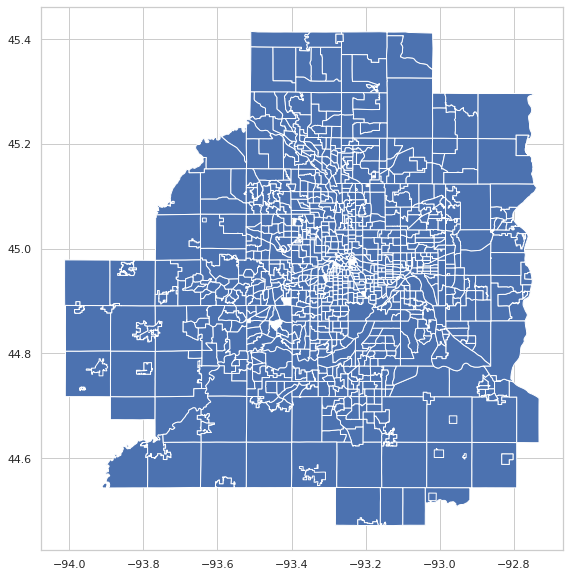

In [103]:
gpd.GeoDataFrame(margins_election.loc[margins_election.year == 2020], geometry="geom").plot()

# Convert vtdid
The VTDID numbering is not continuous.
For exploration purposes I want to switch this to a continguous index.
I aleady merged the data I need using VTDID so this isn't a problem to do.

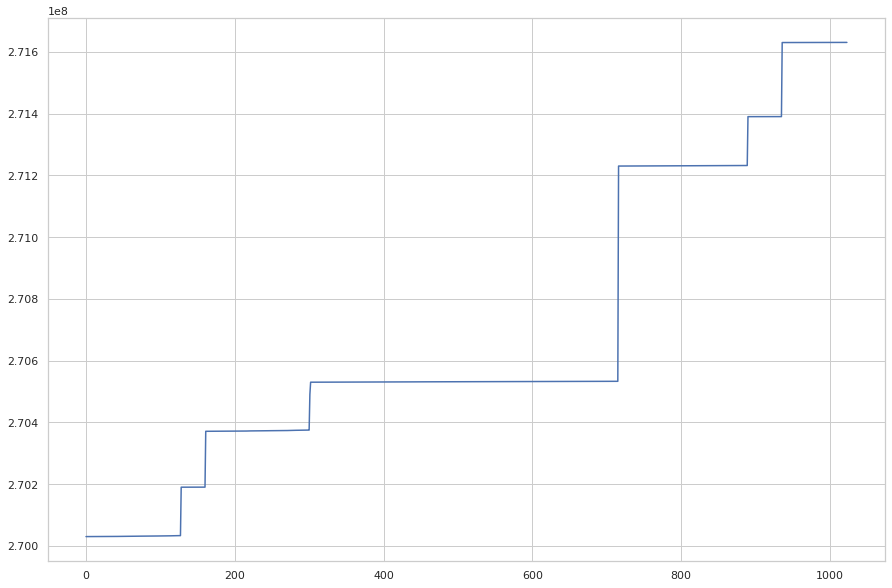

In [104]:
plt.plot(margins_election["vtdid"].sort_values().astype(np.int).unique())
plt.show()

In [105]:
margins_election["vtdid"] = margins_election["vtdid"].astype("category").cat.codes

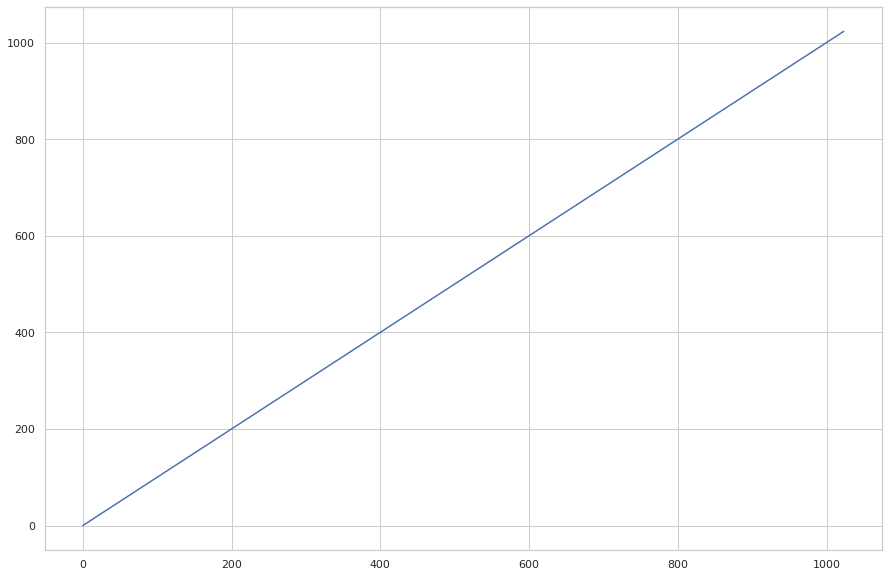

In [106]:
plt.plot(margins_election["vtdid"].sort_values().unique())
plt.show()

# Presidential Data
I will focus on the three presidential datasets included in the parcel election results from 2012, 2016, and 2020.
The

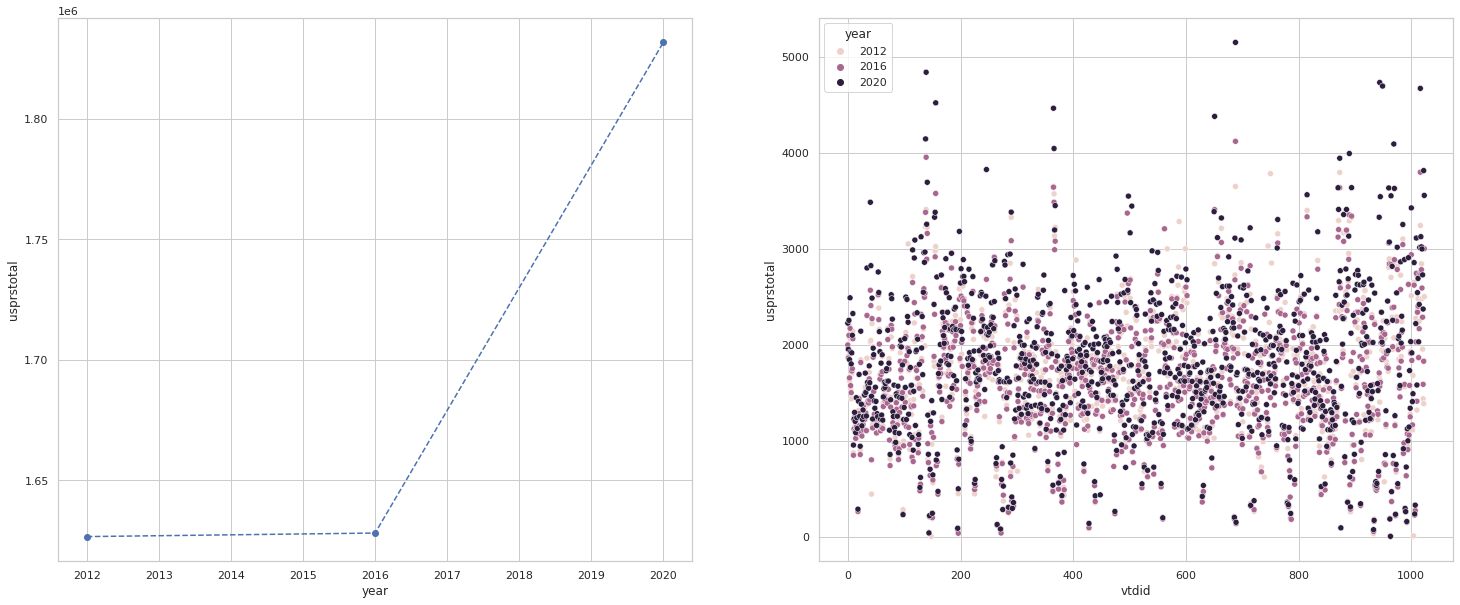

In [107]:
years = [2012, 2016, 2020]
pres_data = margins_election.loc[margins_election.year.isin(years)]
fig, ax = plt.subplots(1, 2, figsize=[25,10])
ax[0].plot(years, pres_data.groupby("year")["usprstotal"].sum(), "--o")
ax[0].set_xlabel("year")
ax[0].set_ylabel("usprstotal")
sns.scatterplot(data=pres_data, x="vtdid", y="usprstotal", hue="year",ax=ax[1])
plt.show()

I am especially interested in margins and margin changes

In [108]:
# Look at change in margins over years
def calculate_margin_change(df):
    row = df.iloc[-1]
    for beg, end in [[2012, 2016], [2016, 2020]]:#, [2012, 2020]]:
        row_beg = df.loc[df.year == beg]
        row_end = df.loc[df.year == end]
        if len(row_beg) > 0 and len(row_end) > 0:
            row[f"{beg}-{end}"] = row_end["usprs_margin"].values[0] - row_beg["usprs_margin"].values[0]
    return row
g = margins_election.groupby("vtdid").apply(calculate_margin_change).unstack().reset_index(drop=True)

/home/bryce/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bryce/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bryce/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bryce/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bryce/.pyenv/versions/3.8.7/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bryce/.pyenv/versions/3.8.7/lib/python3.8/si

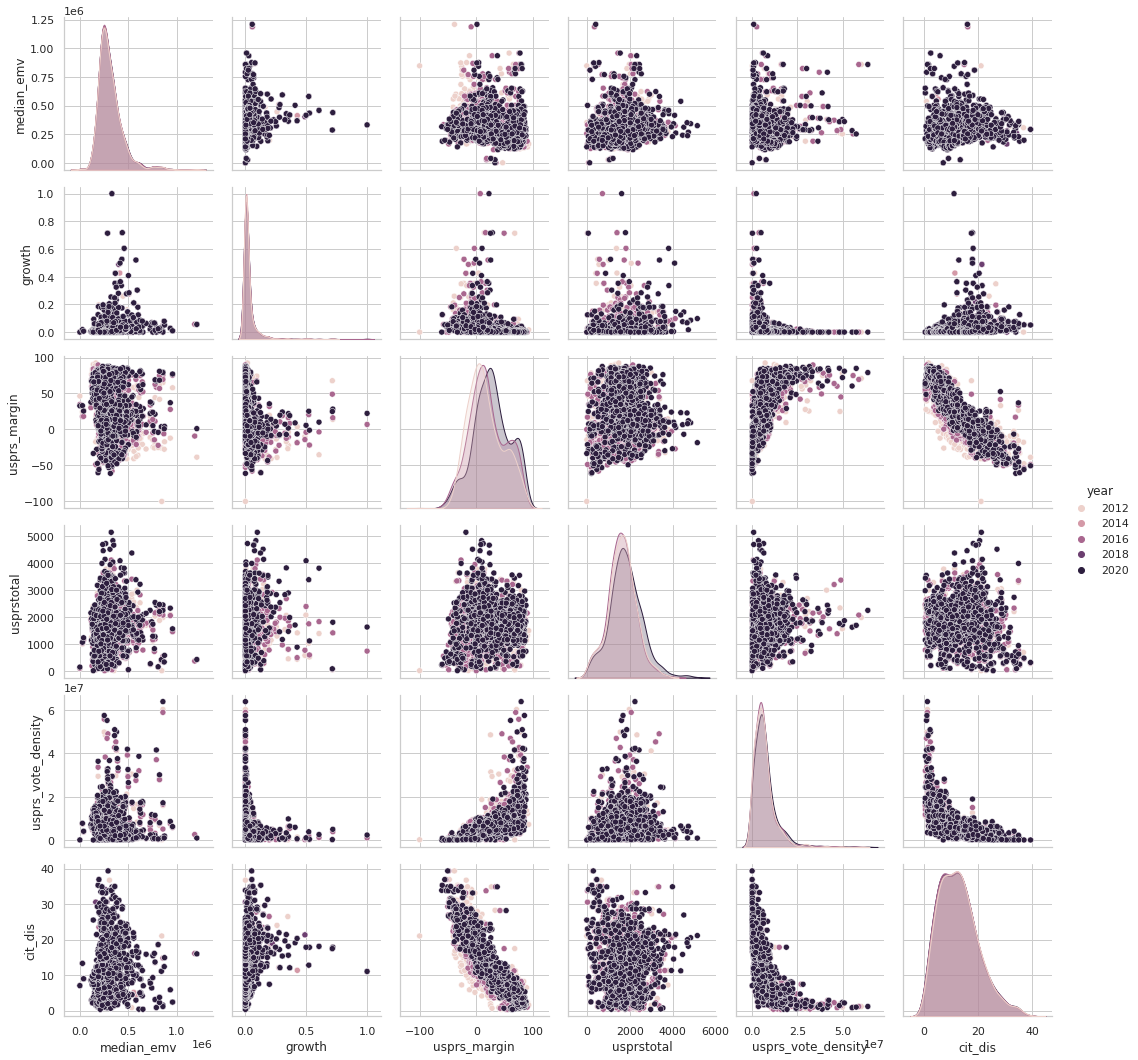

In [109]:
sns.pairplot(data = margins_election[["mean_emv", "growth", "usprs_margin", "year", "usprstotal", "usprs_vote_density", "cit_dis"]], hue='year')

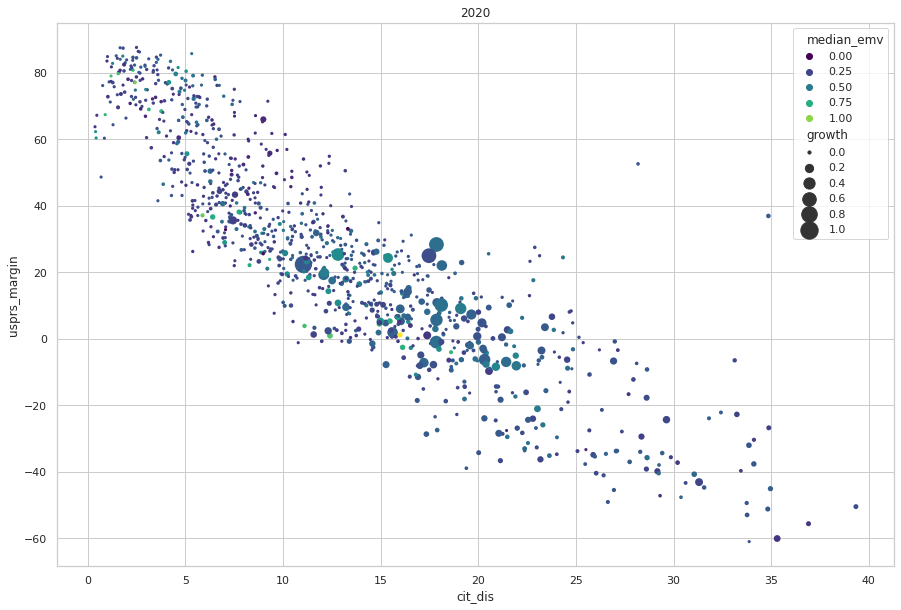

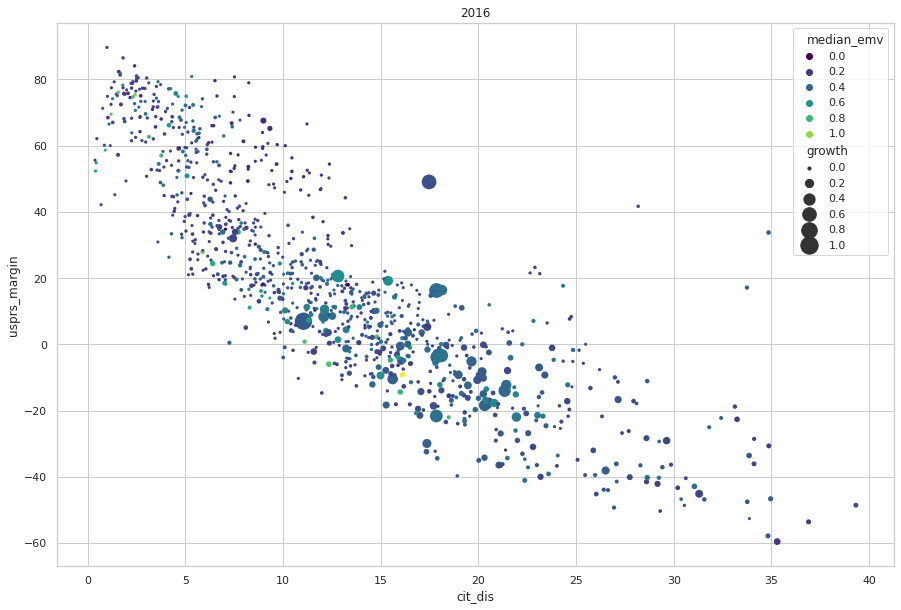

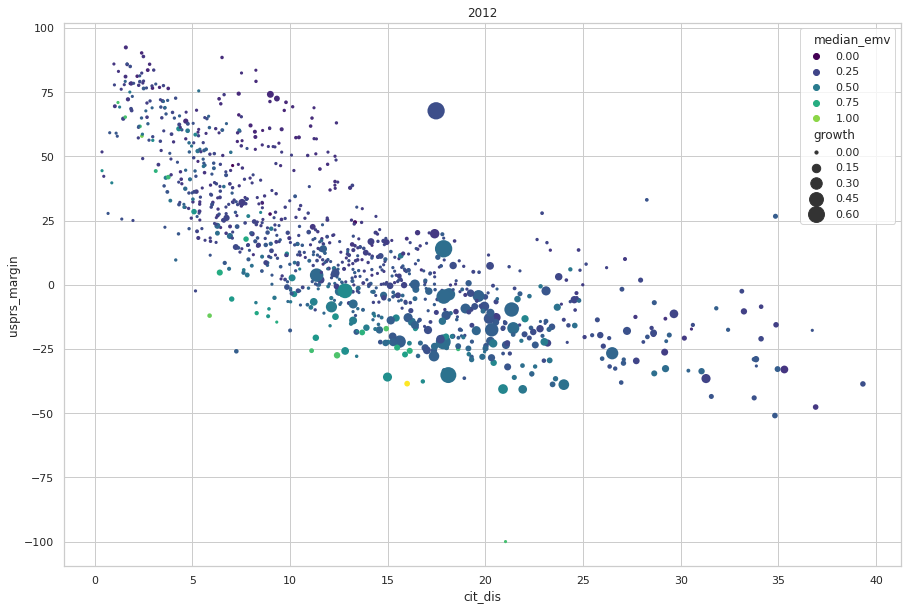

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

for year in [2020, 2016, 2012]:
    d = margins_election.loc[margins_election["year"] == year].dropna(axis=1, how="all")

    fig, ax = plt.subplots(figsize=[15,10])

    ax.set_title(year)
    sns.scatterplot(
        x="cit_dis",
        y="usprs_margin",
        hue="median_emv",
        size="growth",
        sizes=(10, 300),
        palette="viridis",
        linewidth=0,
        data=d
    )
plt.show()

# Voting Patterns in High Growth Areas
From the regional parcel data, there is an encoding of `YEAR_BUILT` which would track well with population growth due to new single family housing developments.
Again, I wish I had better fidelity on the effects of higher density housing because their are likely patterns there as well due to the growth of high density developments in outer ring suburbs in the Twin Cities metro.


In [111]:
# Look at mean of high growth areas over time
def group_growth(val, limits=[0.10, 0.20]):
    if val >= limits[-1]:
        return "High"
    elif val <= limits[0]:
        return "Low"
    else:
        return "Med"
    
margins_election["growth_cat"] = margins_election["growth"].apply(lambda x: group_growth(x))
#pd.cut(margins_election["growth"], 3, labels=["Low", "Med", "High"])
margins_election.groupby(["growth_cat", "year"])["usprs_margin"].describe().dropna(axis=0)

count       mean        std         min        25%  \
growth_cat year                                                       
High       2012   22.0 -10.284887  22.343228  -40.597540 -22.197141   
           2016   25.0  -1.581153  17.323687  -29.958678 -12.271540   
           2020   24.0   9.277679  12.036499   -8.407960   0.325966   
Low        2012  919.0  17.790134  30.323616 -100.000000  -3.759866   
           2016  936.0  21.171157  31.603248  -57.875458  -0.128658   
           2020  937.0  28.556446  31.610830  -61.009174   8.274079   
Med        2012   51.0 -13.207687  14.338334  -40.709459 -22.522626   
           2016   48.0 -10.324621  18.050715  -59.595960 -18.400228   
           2020   47.0  -1.866032  18.796202  -60.082305  -7.770895   

                       50%        75%        max  
growth_cat year                                   
High       2012  -9.444061  -3.868634  67.741935  
           2016  -3.889586   8.348457  49.056604  
           2020   9.070351  20.397886  28.381375  
Low        2012  12.725016  38.516919  92.426273  
           2016  17.749578  45.289202  89.692164  
           2020  27.450980  50.834202  87.674610  
Med        2012 -13.918129  -6.227349  32.015306  
           2016  -9.349544  -0.179148  33.955740  
           2020   0.479819   6.316485  43.373494

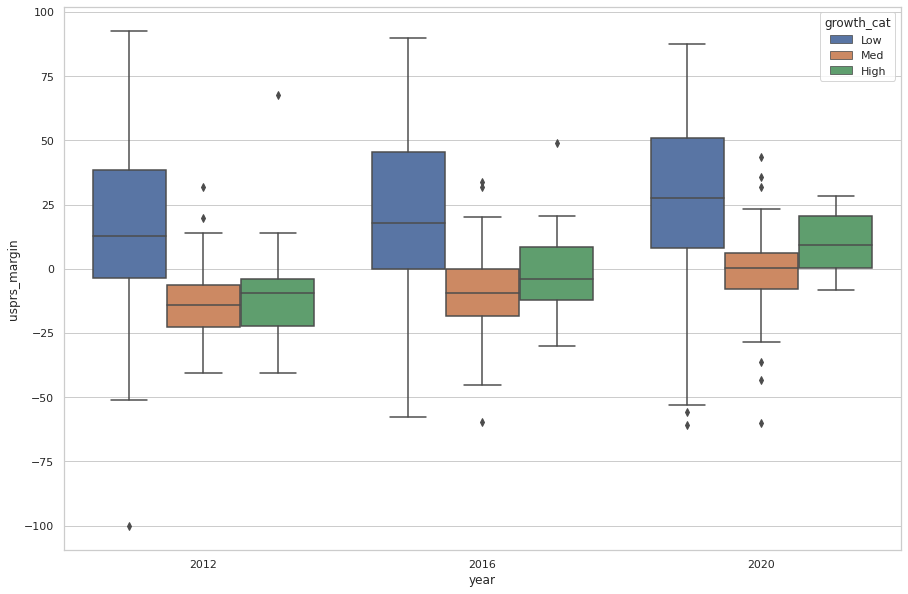

In [112]:
# growth = margins_election.groupby(["year", "growth_cat"])["usprs_margin"].describe().dropna()
# growth
sns.boxplot(data=margins_election.loc[margins_election.year.isin(years)], x="year", y="usprs_margin", hue="growth_cat", dodge=True)
plt.show()

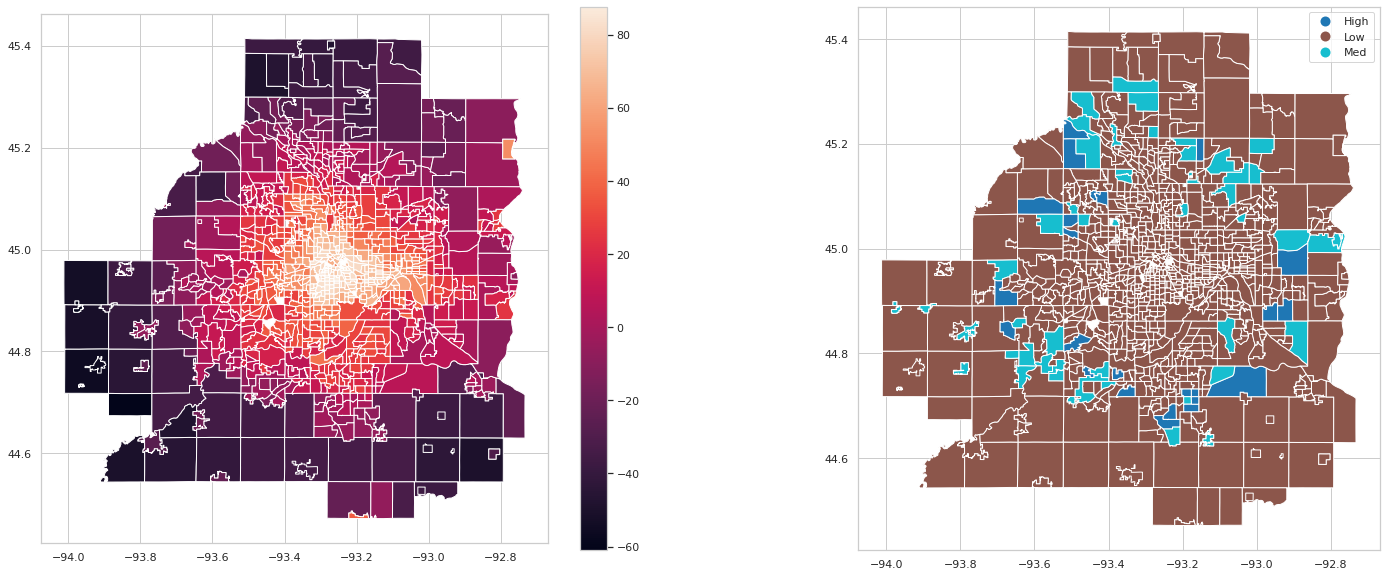

In [113]:
fig, ax = plt.subplots(1, 2, figsize=[25, 10])
gdf = gpd.GeoDataFrame(margins_election.loc[margins_election.year == 2020], geometry="geom")
gdf.crs = 4326
gdf.plot(column="growth_cat", ax=ax[1], legend=True)
gdf.plot(column="usprs_margin", ax=ax[0], legend=True)
plt.show()

# Estimated value trends


In [114]:
# Look at mean of high growth areas over time
margins_election["median_emv_cat"] = pd.cut(margins_election["median_emv"], bins=[0, 150000, 250000, 450000, 600000, np.max(margins_election["median_emv"])])
#pd.cut(margins_election["growth"], 3, labels=["Low", "Med", "High"])
margins_election.groupby(["median_emv_cat", "year"])["usprs_margin"].describe().dropna(axis=0)

count       mean        std         min  \
median_emv_cat        year                                            
(0.0, 150000.0]       2012   25.0  64.069269  16.631282   24.343434   
                      2016   26.0  56.856682  15.830523   17.978620   
                      2020   26.0  50.669139  21.509432  -33.333333   
(150000.0, 250000.0]  2012  325.0  28.159165  26.917041  -47.608696   
                      2016  325.0  24.962697  31.251617  -59.595960   
                      2020  325.0  31.403267  30.217036  -60.082305   
(250000.0, 450000.0]  2012  540.0   8.437847  27.770186  -50.929368   
                      2016  551.0  13.621740  30.811109  -57.875458   
                      2020  548.0  22.305721  32.162208  -61.009174   
(450000.0, 600000.0]  2012   71.0   1.771164  30.942300  -40.709459   
                      2016   72.0  16.317416  30.459411  -37.164751   
                      2020   74.0  24.902970  29.429238  -31.351981   
(600000.0, 1209000.0] 2012   30.0  -1.093503  37.920358 -100.000000   
                      2016   34.0  28.668428  31.735755  -22.058824   
                      2020   34.0  37.343817  30.381926   -4.026846   

                                  25%        50%        75%        max  
median_emv_cat        year                                              
(0.0, 150000.0]       2012  57.446809  66.146646  76.447219  90.273556  
                      2016  51.028375  58.390117  67.946226  84.117125  
                      2020  45.433443  51.311281  66.725824  77.194422  
(150000.0, 250000.0]  2012   9.762364  24.424973  47.204067  92.426273  
                      2016   0.891266  24.592593  49.177489  89.692164  
                      2020   9.393939  33.421284  53.869810  87.674610  
(250000.0, 450000.0]  2012 -10.939791   3.759573  20.379836  86.008837  
                      2016  -6.593728  11.052882  28.671779  86.529319  
                      2020   2.695777  22.337978  40.496214  87.569061  
(450000.0, 600000.0]  2012 -20.311105  -6.645570  16.969140  75.037821  
                      2016  -4.132057   9.979480  28.162089  78.271728  
                      2020   7.100898  20.182520  37.182290  85.046729  
(600000.0, 1209000.0] 2012 -24.865810 -12.336775  25.800199  70.974255  
                      2016   1.626919  17.282701  58.260313  76.135881  
                      2020   7.505542  30.369533  68.213077  81.624567

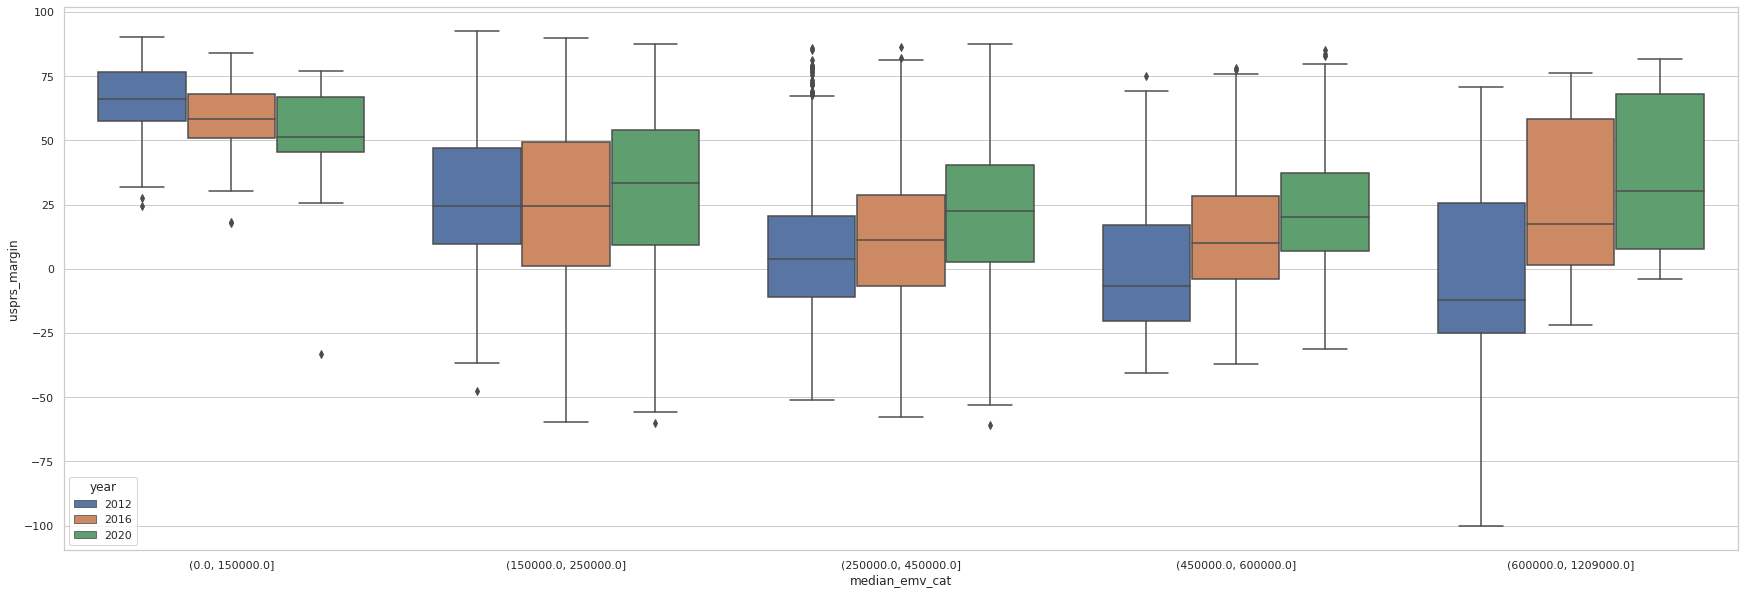

In [115]:
# growth = margins_election.groupby(["year", "growth_cat"])["usprs_margin"].describe().dropna()
# growth
fig, ax = plt.subplots(figsize=[30,10])
sns.boxplot(data=margins_election.loc[margins_election.year.isin(years)], hue="year", y="usprs_margin", x="median_emv_cat", dodge=True)
plt.show()

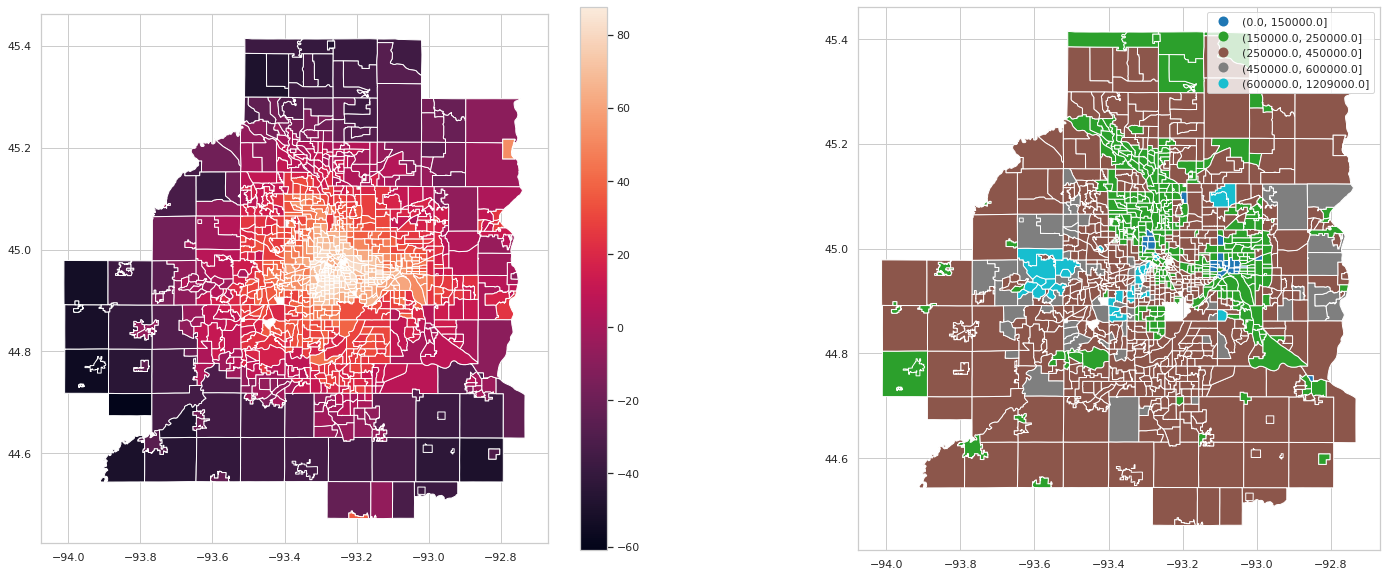

In [116]:
fig, ax = plt.subplots(1, 2, figsize=[25, 10])
gdf = gpd.GeoDataFrame(margins_election.loc[margins_election.year == 2020], geometry="geom")
gdf.crs = 4326
gdf.plot(column="median_emv_cat", ax=ax[1], legend=True)
gdf.plot(column="usprs_margin", ax=ax[0], legend=True)
plt.show()

# Distance trends


In [117]:
# Look at mean of high growth areas over time
margins_election["cit_dis_cat"] = pd.cut(margins_election["cit_dis"], bins=[0, 5, 15, 20, 25, 30, np.max(margins_election["cit_dis"])])
#pd.cut(margins_election["growth"], 3, labels=["Low", "Med", "High"])
margins_election.groupby(["cit_dis_cat", "year"])["usprs_margin"].describe().dropna(axis=0)

count       mean        std         min        25%  \
cit_dis_cat    year                                                       
(0.0, 5.0]     2012  133.0  60.176971  18.198869    9.654851  46.774194   
               2016  145.0  65.216092  13.320895   26.309983  57.041252   
               2020  147.0  72.135095  11.119979   41.540487  65.859235   
(5.0, 15.0]    2012  524.0  21.170169  23.001530  -35.932203   4.883365   
               2016  529.0  25.848022  20.868322  -14.693446  10.760795   
               2020  525.0  34.032171  18.705608   -3.344051  21.110468   
(15.0, 20.0]   2012  181.0  -5.960668  14.620417  -38.500000 -17.107750   
               2016  182.0  -3.134677  12.834213  -39.759036 -11.787364   
               2020  182.0   5.835407  12.698315  -38.933873  -1.755212   
(20.0, 25.0]   2012   94.0 -14.403923  16.664613 -100.000000 -22.698334   
               2016   91.0 -15.268793  15.184792  -41.104294 -25.579223   
               2020   90.0  -8.348016  16.148628  -36.656891 -21.138222   
(25.0, 30.0]   2012   35.0 -17.184461  14.969255  -38.063806 -27.709613   
               2016   38.0 -27.404218  18.178078  -50.381679 -40.220989   
               2020   40.0 -25.037728  19.159145  -49.091853 -37.187693   
(30.0, 39.336] 2012   25.0 -24.525057  16.879721  -50.929368 -33.647799   
               2016   24.0 -35.313060  22.048653  -59.595960 -47.825389   
               2020   24.0 -36.983813  20.598339  -61.009174 -49.669552   

                           50%        75%        max  
cit_dis_cat    year                                   
(0.0, 5.0]     2012  62.686567  76.134700  92.426273  
               2016  68.557634  75.561257  89.692164  
               2020  74.838710  80.894267  87.674610  
(5.0, 15.0]    2012  17.260962  35.521883  88.505747  
               2016  21.159778  37.796834  80.909091  
               2020  31.853583  45.499690  85.803571  
(15.0, 20.0]   2012  -5.312500   4.268943  67.741935  
               2016  -2.400266   5.468286  49.056604  
               2020   6.240278  14.270417  31.205251  
(20.0, 25.0]   2012 -14.945314  -5.226392  27.883397  
               2016 -17.190305  -4.889582  23.223350  
               2020  -7.079027   2.716224  27.514451  
(25.0, 30.0]   2012 -19.640387 -12.866822  33.072407  
               2016 -33.455150 -16.804167  41.698842  
               2020 -33.733918 -11.855886  52.631579  
(30.0, 39.336] 2012 -28.968254 -15.636364  26.675258  
               2016 -43.123664 -27.691405  33.771353  
               2020 -41.930003 -29.477773  36.965812

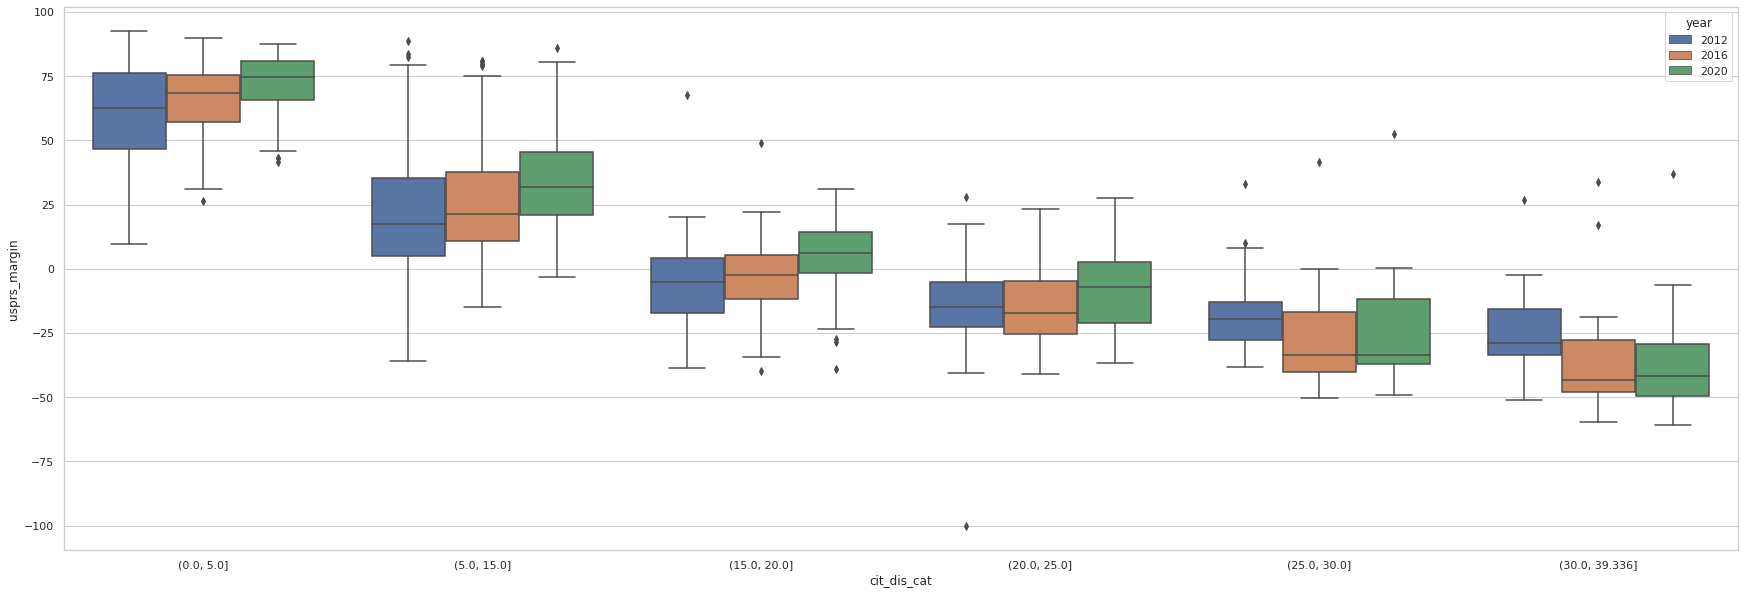

In [118]:
# growth = margins_election.groupby(["year", "growth_cat"])["usprs_margin"].describe().dropna()
# growth
fig, ax = plt.subplots(figsize=[30,10])
sns.boxplot(data=margins_election.loc[margins_election.year.isin(years)], hue="year", y="usprs_margin", x="cit_dis_cat", dodge=True)
plt.show()

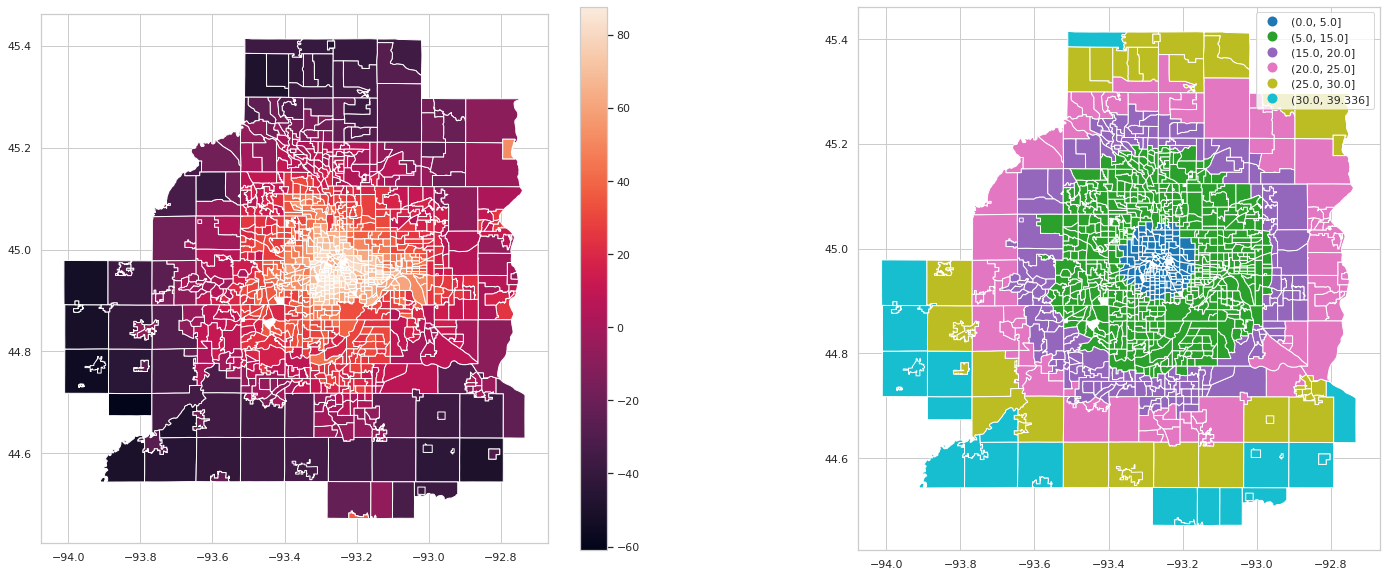

In [119]:
fig, ax = plt.subplots(1, 2, figsize=[25, 10])
gdf = gpd.GeoDataFrame(margins_election.loc[margins_election.year == 2020], geometry="geom")
gdf.crs = 4326
gdf.plot(column="cit_dis_cat", ax=ax[1], legend=True)
gdf.plot(column="usprs_margin", ax=ax[0], legend=True)
plt.show()

In [120]:
margin_cols = [col for col in g.columns if "-20" in col]
id_cols = [col for col in g.columns if "-20" not in col]
margin_change = g.melt(id_vars=id_cols, value_vars = margin_cols, var_name="timeframe", value_name="margin_change")
margin_change

,ab_mb,cit_dis,congdist,countycode,countyfips,countyname,ctu_type,ctycomdist,edr,fedonlyab,...,ussser,usssetotal,ussseua,usssewi,vtd,vtdid,ward,year,timeframe,margin_change
0,1102.0,21.244198,6,2,003,Anoka,city,7,168,3,...,NaN,NaN,NaN,NaN,None,0,None,2020,2012-2016,-9.418509
1,1052.0,18.943586,6,2,003,Anoka,city,7,125,3,...,NaN,NaN,NaN,NaN,None,1,None,2020,2012-2016,-4.218696
2,1177.0,17.187356,6,2,003,Anoka,city,5,168,0,...,NaN,NaN,NaN,NaN,None,2,None,2020,2012-2016,-5.358226
3,964.0,17.487414,6,2,003,Anoka,city,5,163,1,...,NaN,NaN,NaN,NaN,None,3,None,2020,2012-2016,-3.432119
4,1358.0,19.28922,6,2,003,Anoka,city,2,173,3,...,NaN,NaN,NaN,NaN,None,4,None,2020,2012-2016,5.541741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2169.0,18.811589,4,82,163,Washington,city,5,199,6,...,NaN,NaN,NaN,NaN,None,1019,None,2020,2016-2020,8.173196
2044,1831.0,19.131102,4,82,163,Washington,city,5,119,5,...,NaN,NaN,NaN,NaN,None,1020,None,2020,2016-2020,10.24617
2045,1633.0,16.386299,4,82,163,Washington,city,4,124,2,...,NaN,NaN,NaN,NaN,None,1021,None,2020,2016-2020,10.615737
2046,2704.0,18.1031,4,82,163,Washington,city,5,207,2,...,NaN,NaN,NaN,NaN,None,1022,None,2020,2016-2020,13.562065


<AxesSubplot:xlabel='median_emv', ylabel='margin_change'>

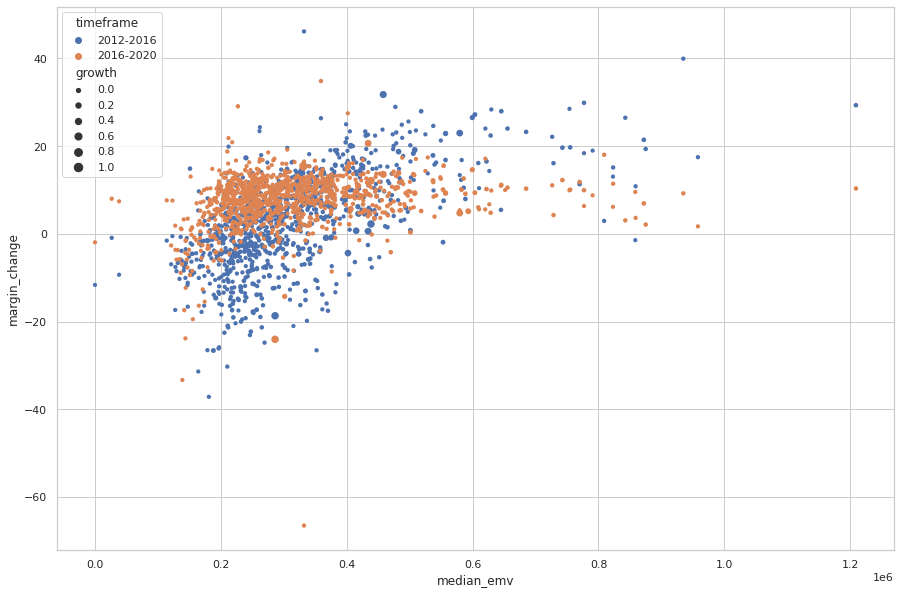

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


fig, ax = plt.subplots(figsize=[15,10])

sns.scatterplot(
    x="median_emv",
    y="margin_change",
    size="growth",
    hue="timeframe",
#         palette="ch:r=-.2,d=.3_r",
    ax=ax,
    linewidth=0,
    data=margin_change
)
# sns.scatterplot(
#     x="median_emv",
#     y="usprsdfl",
#     size="growth",
#     hue="timeframe",
# #         palette="ch:r=-.2,d=.3_r",
#     ax=ax2,
#     linewidth=0,
#     data=margin_change.loc[margin_change.year.isin([2012,2016,2020])]
# )

In [122]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
# X_cols = ["median_emv", "median_age", "growth", "cit_dis", "usprs_vote_density"]
X_cols = ["cit_dis", "growth", "usprs_vote_density", "median_emv", "median_age"]
Y_cols = ["usprs_margin"]
# There is one that has a zero value

year_mask = margins_election.year == 2020
input_data = margins_election.loc[year_mask]
input_data=input_data.loc[input_data["median_emv"] != 0]
X = (input_data[X_cols] - input_data[X_cols].mean())/input_data[X_cols].std()
Y = input_data[Y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, Y)


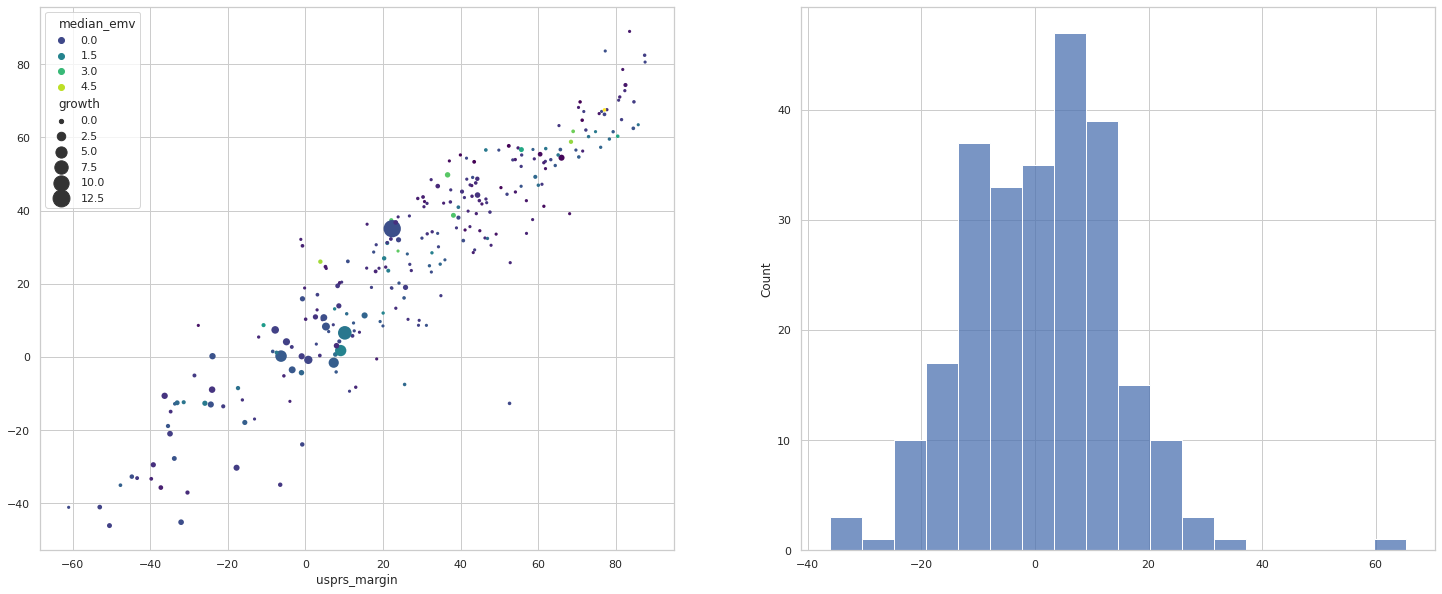

In [123]:
pls = PLSRegression(n_components=4)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
fig, [ax, ax2] = plt.subplots(1,2, figsize=[25,10])
# pred_data = pd.concat([X_test, y_test, pd.Series(np.squeeze(y_pred), name="predict")], ignore_index=True)
# pred_data
sns.scatterplot(
        x=y_test["usprs_margin"],
        y=np.squeeze(y_pred),
        hue=X_test["median_emv"],
        size=X_test["growth"],
        sizes=(10, 300),
        palette="viridis",
        linewidth=0,
#         data=pred_data
    ax=ax
    )
# sns.scatterplot(x=y_test, y=pls.predict(X_test), hue="")
sns.histplot(y_test["usprs_margin"].values - np.squeeze(y_pred), ax=ax2)
# sns.scatterplot(
#         x=y_test["usprs_margin"],
#         y=y_test["usprs_margin"].values - np.squeeze(y_pred),
# #         hue=X_test["median_emv"],
# #         size=X_test["growth"],
#         sizes=(10, 300),
#         palette="viridis",
#         linewidth=0,
# #         data=pred_data
#     ax=ax2
#     )
# ax2.plot(y_test - y_pred, "o")
plt.show()

# Train Keras model


0       False
1       False
2       False
3       False
4       False
        ...  
2043    False
2044    False
2045    False
2046    False
2047    False
Length: 2048, dtype: bool

In [165]:
import tensorflow as tf
X_cols = ["cit_dis", "growth", "usprs_vote_density", "mean_emv", "median_emv", "median_age", "mean_age"]
Y_cols = ["margin_change"]
# There is one that has a zero value

year_mask = (margin_change.year == 2020) & (margin_change.timeframe == "2016-2020") & (margin_change["margin_change"].notna())
input_data = margin_change.loc[year_mask]
input_data=input_data.loc[input_data["median_emv"] != 0]
X = (input_data[X_cols] - input_data[X_cols].mean())/input_data[X_cols].std()
Y = input_data[Y_cols]
dataset = tf.data.Dataset.from_tensor_slices((X.values.astype(np.float), Y.values.astype(np.float)))
train_dataset = dataset.shuffle(len(input_data)).batch(1)

# X_train, X_test, y_train, y_test = train_test_split(X, Y)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, input_shape=(len(X_cols),)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
    ]
)
model.fit(train_dataset, epochs=100)


Epoch 1/100
999/999 [==============================] - 1s 691us/step - loss: 49.4178 - mean_squared_error: 49.4178
Epoch 2/100
999/999 [==============================] - 1s 922us/step - loss: 30.6802 - mean_squared_error: 30.6802
Epoch 3/100
999/999 [==============================] - 1s 784us/step - loss: 31.1259 - mean_squared_error: 31.1259
Epoch 4/100
999/999 [==============================] - 1s 902us/step - loss: 27.9468 - mean_squared_error: 27.9468
Epoch 5/100
999/999 [==============================] - 1s 759us/step - loss: 22.6461 - mean_squared_error: 22.6461
Epoch 6/100
999/999 [==============================] - 1s 937us/step - loss: 23.9579 - mean_squared_error: 23.9579
Epoch 7/100
999/999 [==============================] - 1s 864us/step - loss: 19.9559 - mean_squared_error: 19.9559
Epoch 8/100
999/999 [==============================] - 1s 826us/step - loss: 23.4326 - mean_squared_error: 23.4326
Epoch 9/100
999/999 [==============================] - 1s 894us/step - loss: 23.

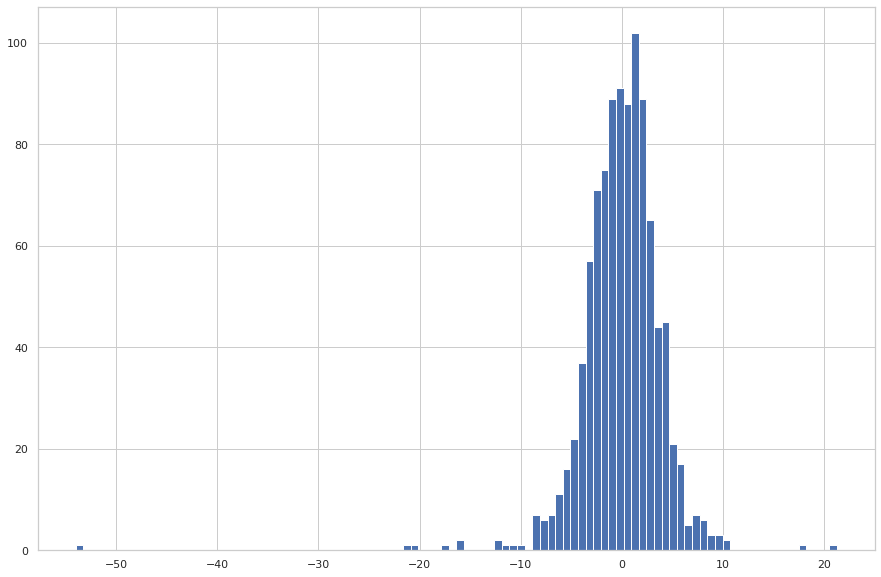

In [169]:
predictions = model(X.values.astype(np.float)).numpy()
d = plt.hist(Y.values - predictions, bins=100)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='margin_change', ylabel='predict_resd'>

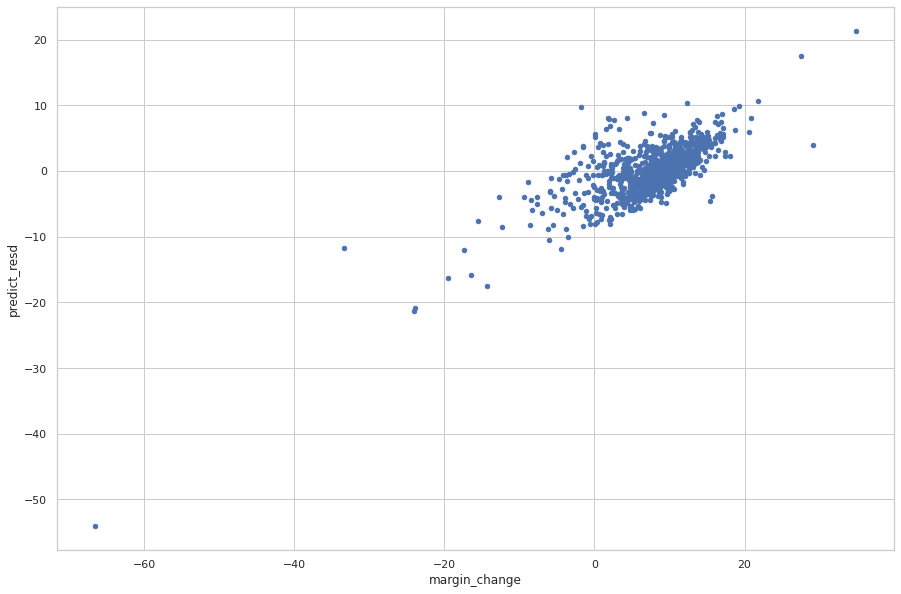

In [170]:
gdf[["margin_change", "predict_resd"]].plot.scatter(x="margin_change", y="predict_resd")

<AxesSubplot:>

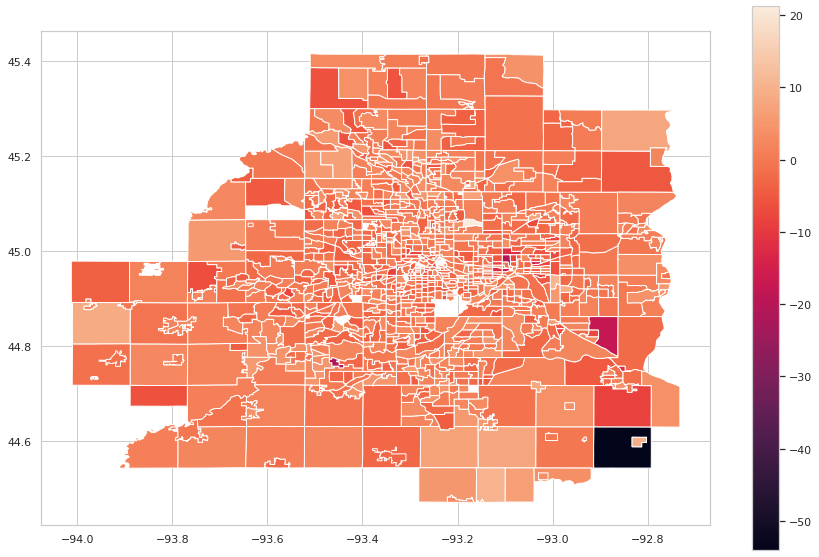

In [171]:
gdf = gpd.GeoDataFrame(input_data, geometry="geom")
gdf["predict"] = predictions.astype(np.float)
gdf["predict_resd"] = (Y.values - predictions).astype(np.float)
gdf.plot(column="predict_resd", legend=True)